In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp
from scipy import stats

import model
# import model as model
# %load_ext snakeviz
from collections import OrderedDict

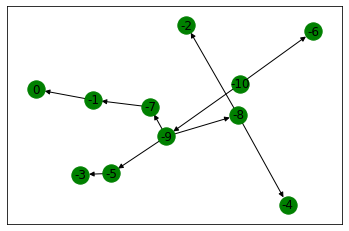

In [2]:
R0=2.0
params_perfect_tracing = {'patient0_hist':'equil', 'R0':R0, 'delay':0, 
                         'loss':0, 'iso_fac':0.1, 'test_fac':0.2}
tree0 = model.Tree.get_equil_infection_hist(R0=2.0)

nx.draw_networkx(tree0.G, with_label = True, node_color ='green') 

In [3]:
test_time = model.Tree.get_patient0_test_time()
print(test_time)

params_no_testing = {'R0':R0, 'delay':0, 
                         'loss':0, 'iso_fac':0.1, 'test_fac':0.}

tree = model.Tree(G=tree0.G, **params_no_testing)

tree.run_sim(tspan_days=test_time/24, verbose=True)

174
Ignore patient0_hist option, using initial graph tree G instead.
Starting simulation for 7.25 days

1: I-8->1
21: I-3->2
30: I-6->3
34: I-1->4
44: I-7->5
51: R-9
52: I-4->6
56: I-5->7
59: I-1->8
67: I-1->9
81: I1->10
108: I1->11
112: I1->12
121: I4->13
126: R-8 I8->14
138: I-2->15
146: I2->16
151: R-7
152: I4->17
155: R-6


In [4]:

def draw_infect_hist(G, pruned_active_nodes=None):
    t_infect = [t for (ind, t) in list(G.nodes(data='t_infect'))]
    
    node_id_dat = list(G.nodes(data='recovered'))
                       
    node_ids0= np.array(list(G.nodes))
    rec0 = np.array([rec for (i,rec) in G.nodes(data='recovered')])

    ind_sort = np.argsort(node_ids0)
    node_ids = node_ids0[ind_sort]

    recovered = rec0[ind_sort]
    active = -2*recovered
    
    node_id_patient0 = np.where(node_ids==0)[0]
    active[node_id_patient0] =  +2
    # active[-1] = +2

    if pruned_active_nodes is not None:
        # pruned_active_ind = [node_id for node_id in node_ids 
        #                      if node_id in pruned_active_nodes]
        pruned_active_mask = [node_id in pruned_active_nodes 
                              for node_id in node_ids]
        # pruned_active_ind = np.array(pruned_active_nodes)-1
        active[pruned_active_mask] = -1
                       
                       
    # active = -2.0*np.array([rec for (ind, rec) in list(G.nodes(data='recovered'))])
    #                    
    # for (ind, rec) in node_ids:
    #     print()
    # active = -2.0*np.array([rec for (ind, rec) in list(G.nodes(data='recovered'))])
    # active[-1] = +2
    # 
    # if pruned_active_nodes is not None:
    #     print([ind for (ind, rec) in list(G.nodes(data='recovered'))]    )
    #     active[np.array(pruned_active_nodes)-1] = -1
    
    plt.figure()
    nx.draw_networkx(G, node_color=active, cmap='coolwarm_r', vmin=-2, vmax=+2)
    
    # plt.figure()
    # nx.draw_networkx(G, node_color=t_infect, cmap='Wistia_r')

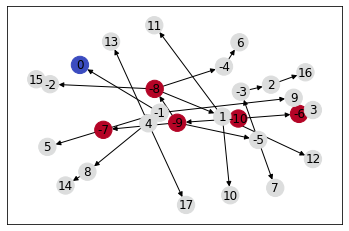

In [5]:

# draw_infect_hist(tree.G, pruned_active_nodes=pruned_active_nodes)
draw_infect_hist(tree.G)

In [6]:
def get_ancestor_root(tree):
    G = tree.G
    Nnode = G.number_of_nodes()
    recovered = np.tile(False, Nnode)
    node_ids = np.zeros(Nnode, dtype=int)
    
    for ind, (inode, irecov) in enumerate(G.nodes(data='recovered')):
        # ind = inode+Nnode-1
        # print('inode = ', inode)
        # print('ind = ', ind)
        node_ids[ind] = inode
        recovered[ind] = irecov
        
    recovered_nodes = node_ids[recovered]
    
    branch_roots = []
    for inode in recovered_nodes:
        ineigh = list(nx.neighbors(G, inode))
        unrecovered_neigh = [ind for ind in ineigh if ind not in recovered_nodes]
        branch_roots.extend(unrecovered_neigh)
        
    branch_roots = np.array(branch_roots)
    
    # mask = np.array([0 in nx.descendants(G, i) for i in branch_roots])
    
    mask = np.tile(False, len(branch_roots))
    for ind, iroot in enumerate(branch_roots):
        idescendants = nx.descendants(G,iroot)
        if (iroot==0) or (0 in idescendants):
            mask[ind] = True
            
    
    ancestor_root = branch_roots[mask][0]

    return ancestor_root, recovered_nodes

In [7]:
ancestor_root, recovered_nodes = get_ancestor_root(tree)
print('recovered_nodes = ', recovered_nodes)
print('ancestor_root = ', ancestor_root)

recovered_nodes =  [-10  -9  -8  -7  -6]
ancestor_root =  -1


In [8]:
pruned_G, pruned_active_nodes = model.Tree.prune_ancestor_root(
    tree, ancestor_root, recovered_nodes)

print('pruned_active_nodes = ', pruned_active_nodes)
pruned_G.nodes()

pruned_active_nodes =  [-5, -4, -3, -2, 1, 2, 3, 5, 6, 7, 10, 11, 12, 15, 16]


NodeView((-1, 0, 4, 8, 9, 13, 14, 17))

In [9]:
pruned_G.nodes(data=True)[0]

{'isolated': False, 'recovered': False, 't_infect': 0}

In [10]:
# Reset clock to 0 at test-time for patient0
for node_id in pruned_G.nodes:
    pruned_G.nodes[node_id]['t_infect'] -= test_time


In [11]:
pruned_G.nodes(data=True)[0]

{'isolated': False, 'recovered': False, 't_infect': -174}

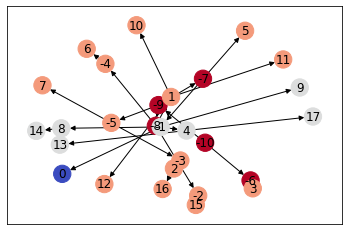

In [12]:

draw_infect_hist(tree.G, pruned_active_nodes=pruned_active_nodes)

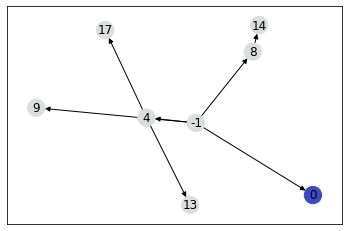

In [13]:
draw_infect_hist(pruned_G)